In [1]:
## -- Set Device-Agnostic code --
import torch
print(f"ℹ️ Cuda available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    get_ipython().run_line_magic('load_ext', 'cuml.accel')
else:
    pass

ℹ️ Cuda available: False


In [2]:
## -- IMPORT LIBRARIES --
import sys, os, gc

## -- DATA MANIPUALATION --
import numpy as np, pandas as pd, random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

## -- FUNCTIONAL TOOLS --
from time import time, sleep
from tqdm.auto import tqdm
from itertools import combinations, product

## -- MACHINE LEARNING --
import sklearn

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, mean_squared_error

import warnings

In [3]:
print(f"sklearn version: {sklearn.__version__}")

sklearn version: 1.2.2


In [4]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
# plt.style.use("ggplot")
sns.set_style("darkgrid")
# sns.set_palette("tab10")
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [5]:
## -- Load Data --
PATH = "/kaggle/input/playground-series-s5e10/"
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
submit = pd.read_csv(PATH+"sample_submission.csv")

ORIG_PATH = "/kaggle/input/simulated-roads-accident-data/"
orig = pd.concat([pd.read_csv(ORIG_PATH+"synthetic_road_accidents_100k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_10k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")],
            ignore_index=True)

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} has shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")

Train has shape: (517754, 13)
Test has shape: (172585, 12)
Original has shape: (112000, 13)

Total Numerical: 4
Total Categorical: 8


In [6]:
train.head(3)

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 41.5+ MB


In [8]:
# print(f"Train ID column is Unique: {train.id.is_unique}")
# print(f"Test ID column is Unique: {test.id.is_unique}")

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
num_lanes,517754.0,2.491511,1.120434,1.0,1.00,2.00,3.00,4.0
curvature,517754.0,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,46.112575,15.788521,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,517754.0,1.187970,0.895961,0.0,1.00,1.00,2.00,7.0
accident_risk,517754.0,0.352377,0.166417,0.0,0.23,0.34,0.46,1.0


In [10]:
train.describe(exclude='number').T

,count,unique,top,freq
road_type,517754,3,highway,173672
lighting,517754,3,dim,183826
weather,517754,3,foggy,181463
road_signs_present,517754,2,False,259289
public_road,517754,2,True,260045
time_of_day,517754,3,morning,173410
holiday,517754,2,True,260688
school_season,517754,2,False,260164


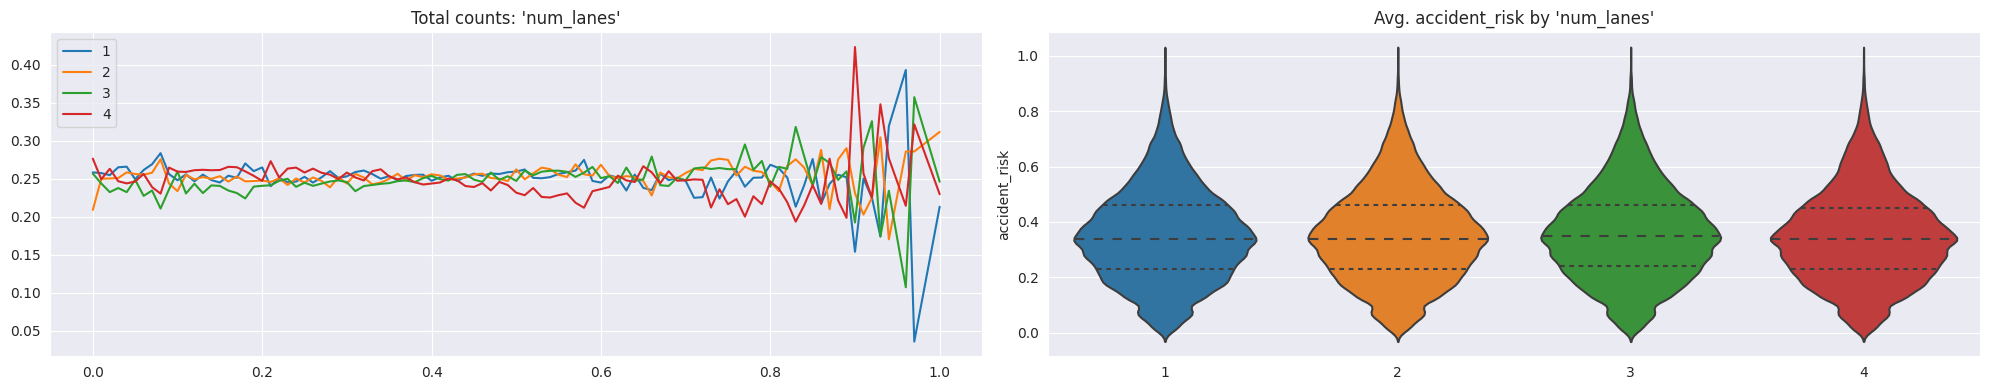

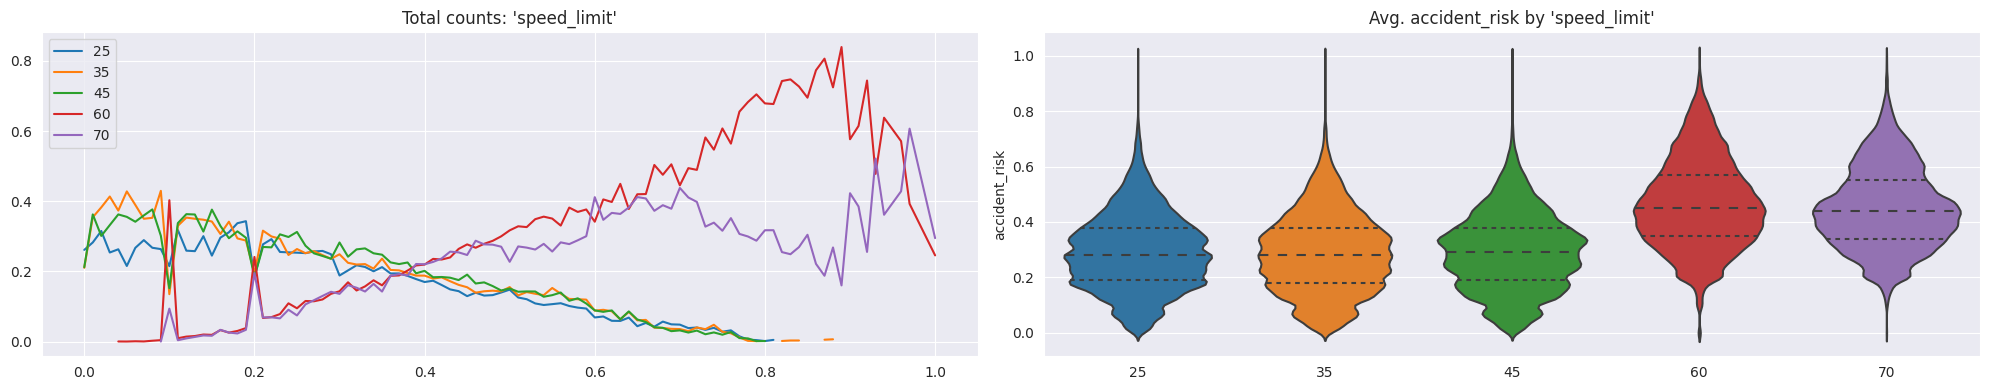

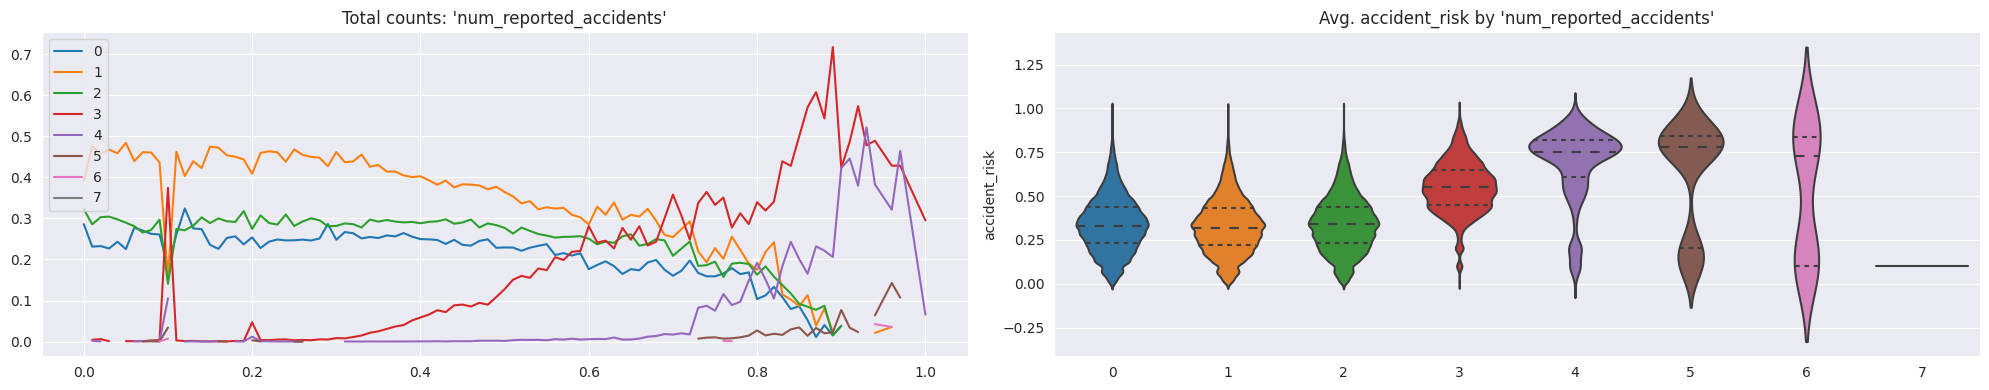

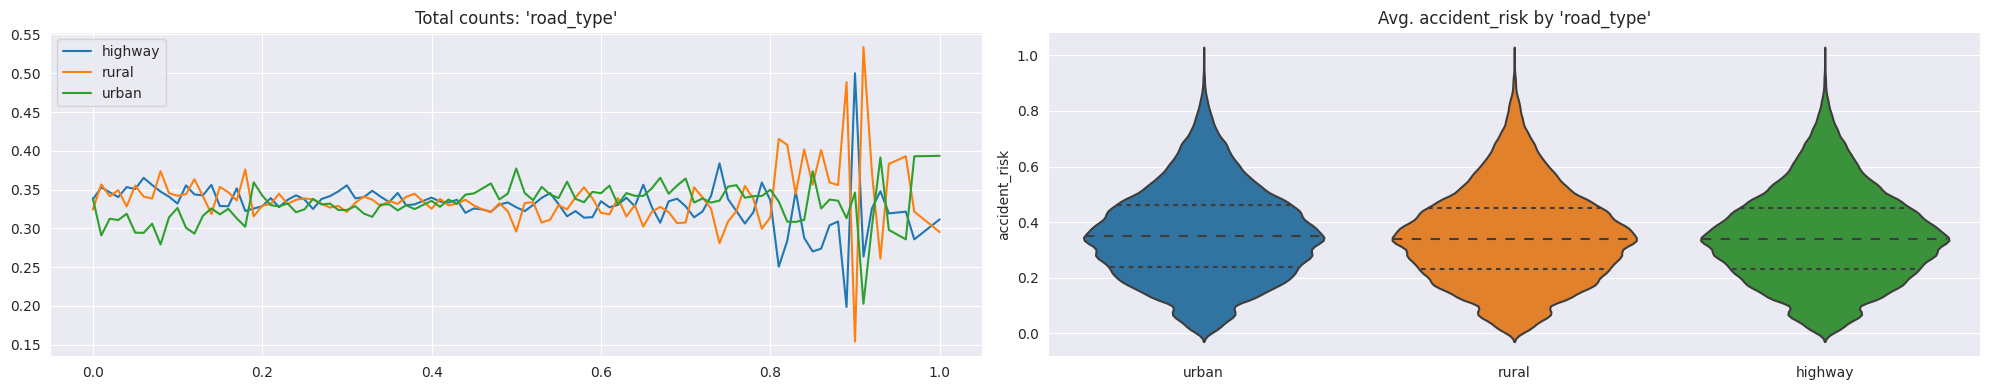

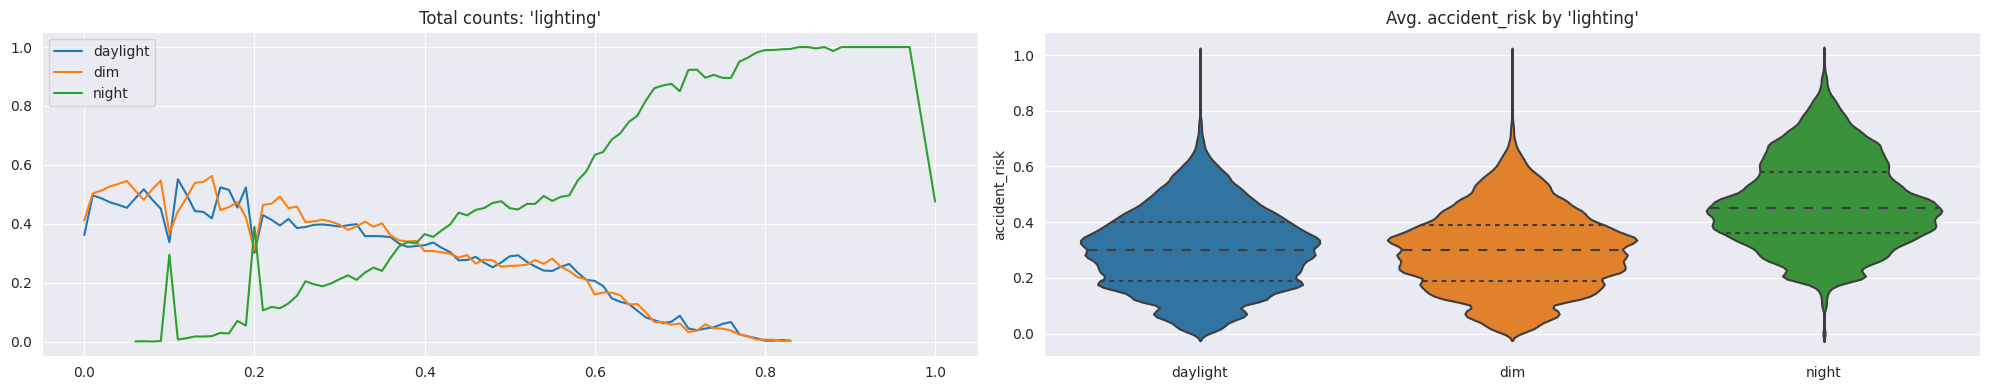

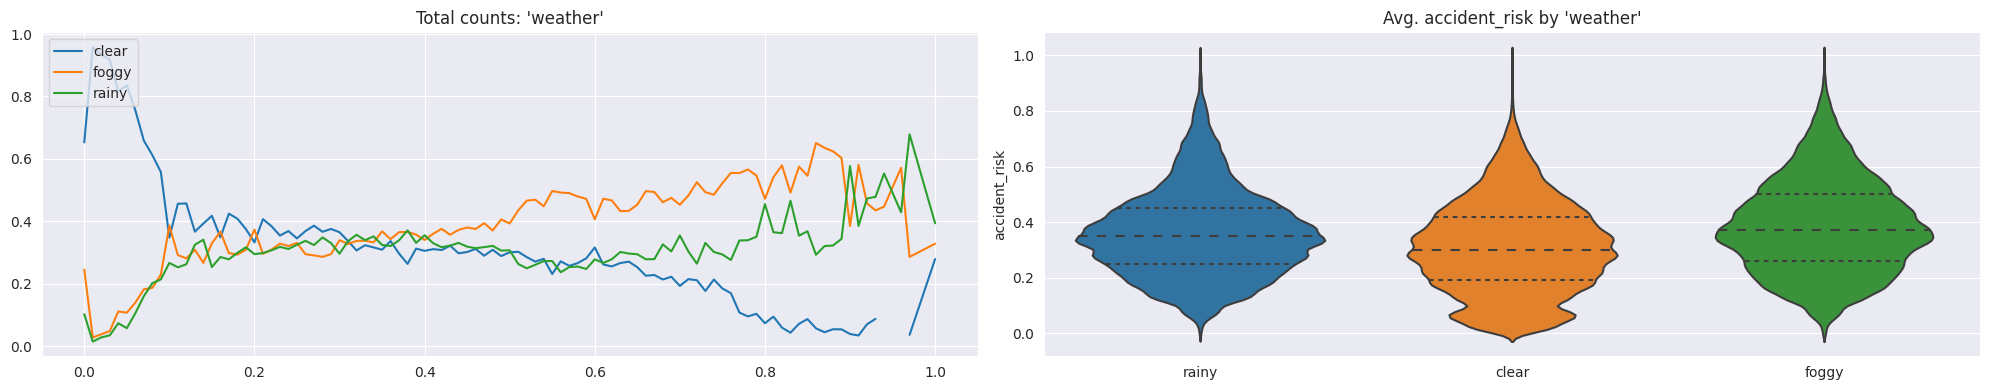

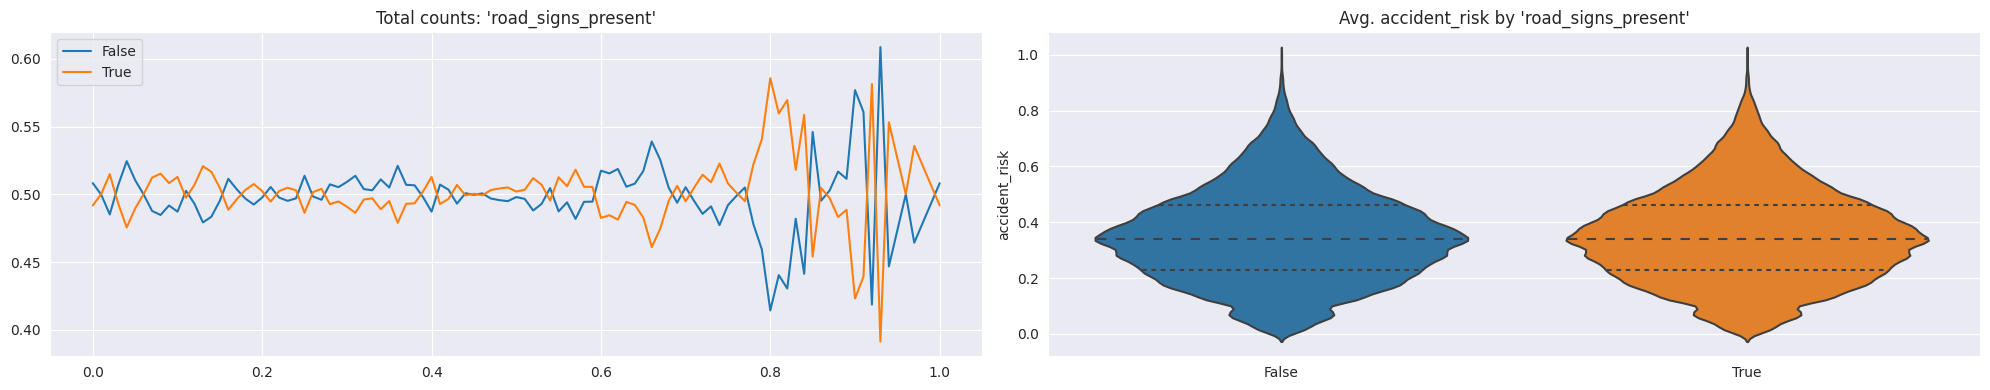

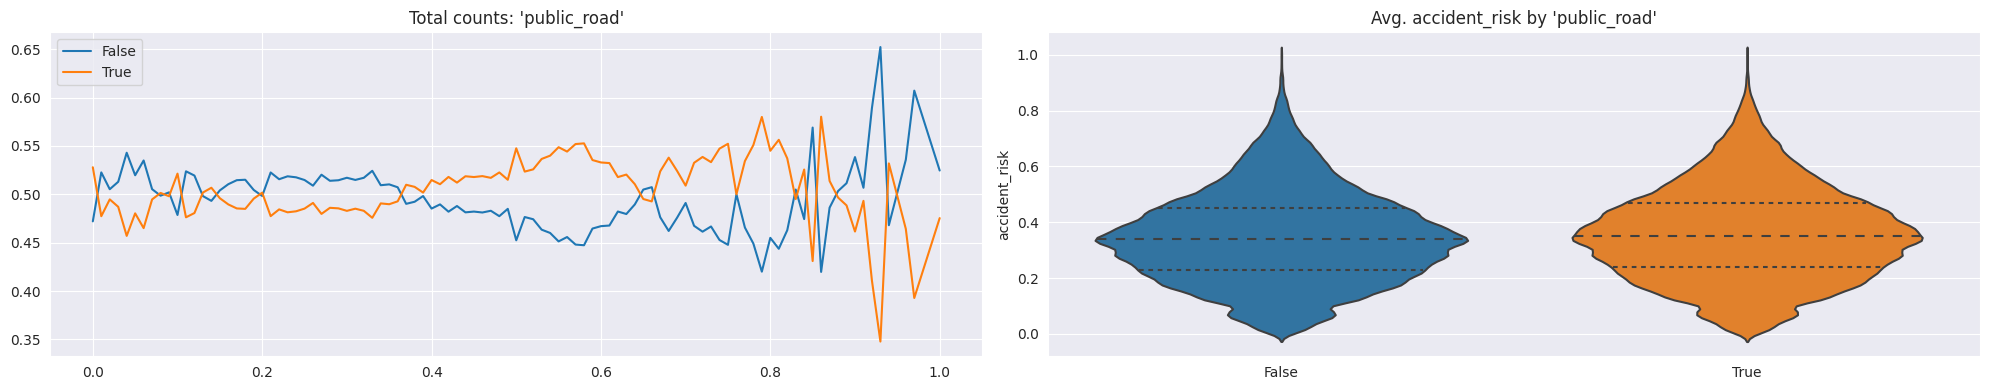

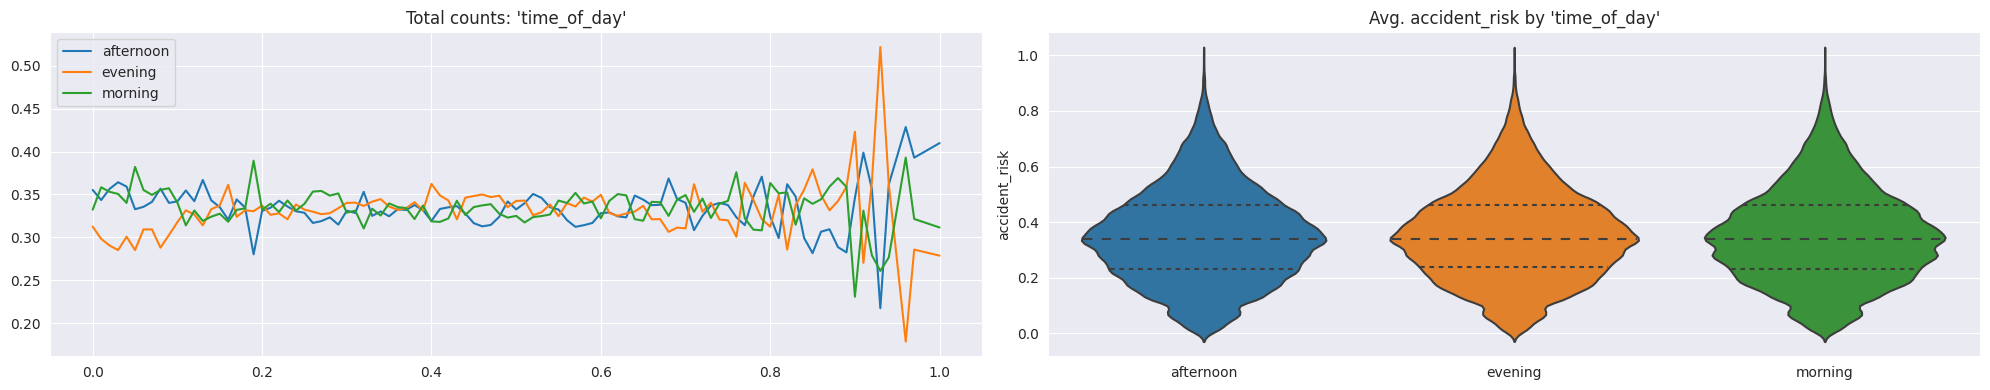

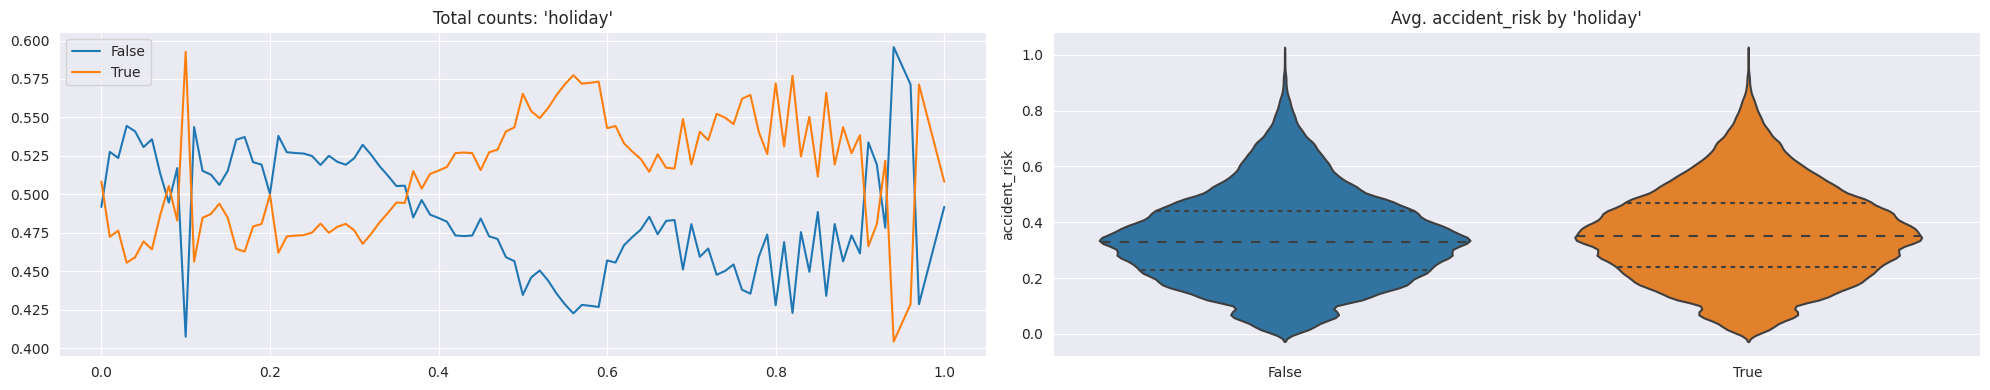

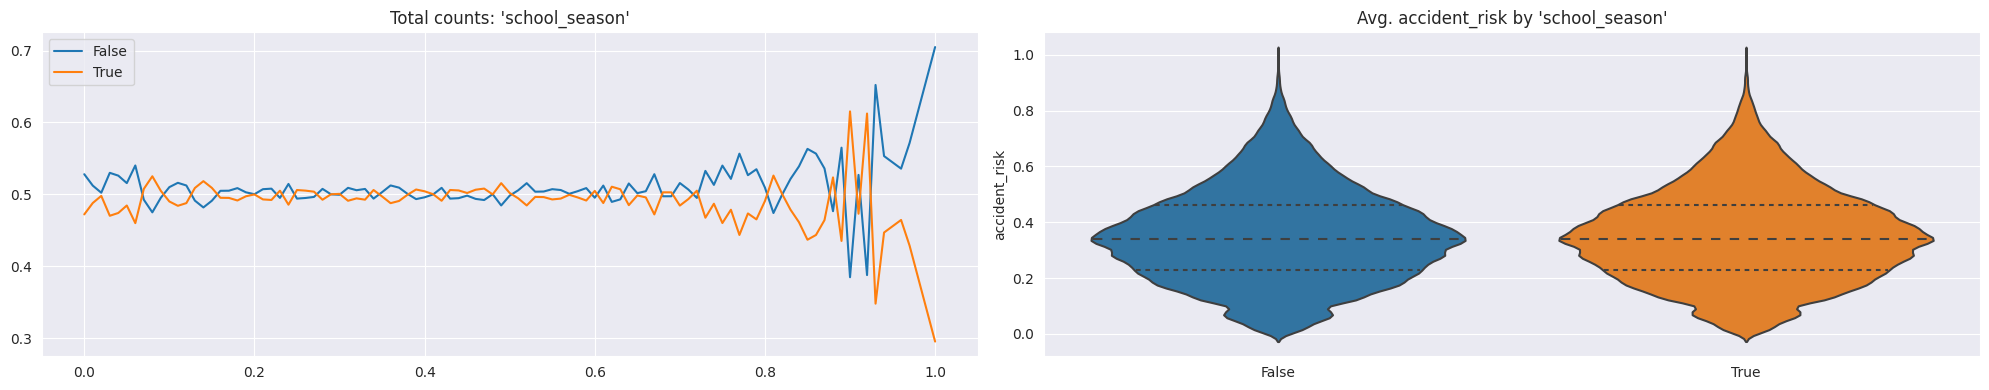

In [11]:
## -- Categorical Features: Counts/Mean by TARGET --
cat_cols = [c for c in FEATURES if c not in ['curvature']]
for c in cat_cols:
    _, axs = plt.subplots(1, 2, figsize=(20, 4))
    axs = axs.flatten()
    values = train.groupby(TARGET)[c].value_counts(normalize=True).unstack()
    values.plot(ax=axs[0])
    axs[0].set_title(f"Total counts: '{c}'")
    axs[0].set_xlabel("")
    axs[0].legend(loc='upper left')

    sns.violinplot(data=train, x=c, y=TARGET, ax=axs[1], inner='quart', palette='tab10')
    axs[1].set_title(f"Avg. {TARGET} by '{c}'")
    axs[1].set_xlabel("")

    plt.tight_layout()
    plt.show()

## FEATURE ENGINEERING

In [12]:
display(train.head(3))
train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30


<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 41.5+ MB


In [13]:
print(train.nunique())

road_type                   3
num_lanes                   4
curvature                 261
speed_limit                 5
lighting                    3
weather                     3
road_signs_present          2
public_road                 2
time_of_day                 3
holiday                     2
school_season               2
num_reported_accidents      8
accident_risk              98
dtype: int64


### ML TRAINING

In [14]:
model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore', drop='first', dtype=int), cat_cols),
        remainder='passthrough', n_jobs=-1,
    ),
    LinearRegression(),
)
X, y = train[FEATURES], train[TARGET]
model.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore'),
                                                  ['num_lanes', 'speed_limit',
                                                   'num_reported_accidents',
                                                   'road_type', 'lighting',
                                                   'weather',
                                                   'road_signs_present',
                                                   'public_road', 'time_of_day',
                                                   'holiday',
                                                   'school_season'])])),
                ('linearregression', LinearRegression())])

This is the author's data creation formula, which we can derive from the model coefficients

```python
for df in [train, test, orig]:
    base_risk = (
        0.3 * df["curvature"] +
        0.2 * (df["lighting"] == "night").astype(int) +
        0.1 * (df["weather"] != "clear").astype(int) +
        0.2 * (df["speed_limit"] >= 60).astype(int) +
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
        )
    df['meta'] = base_risk

FEATURES.append('meta')

In [15]:
## -- Get feature names and importance values --
feature_names = model[0].get_feature_names_out(X.columns)
importances = model[-1].coef_
imp = dict(Feature=feature_names, Importances=importances)
imp_df = pd.DataFrame(imp).sort_values("Importances", ascending=False)

imp_df.iloc[:10, :]

,Feature,Importances
26,remainder__curvature,0.304603
17,onehotencoder__lighting_night,0.190907
6,onehotencoder__speed_limit_70,0.187787
5,onehotencoder__speed_limit_60,0.186114
9,onehotencoder__num_reported_accidents_3,0.096913
19,onehotencoder__weather_rainy,0.093316
18,onehotencoder__weather_foggy,0.092799
10,onehotencoder__num_reported_accidents_4,0.088467
11,onehotencoder__num_reported_accidents_5,0.055240
12,onehotencoder__num_reported_accidents_6,0.019012


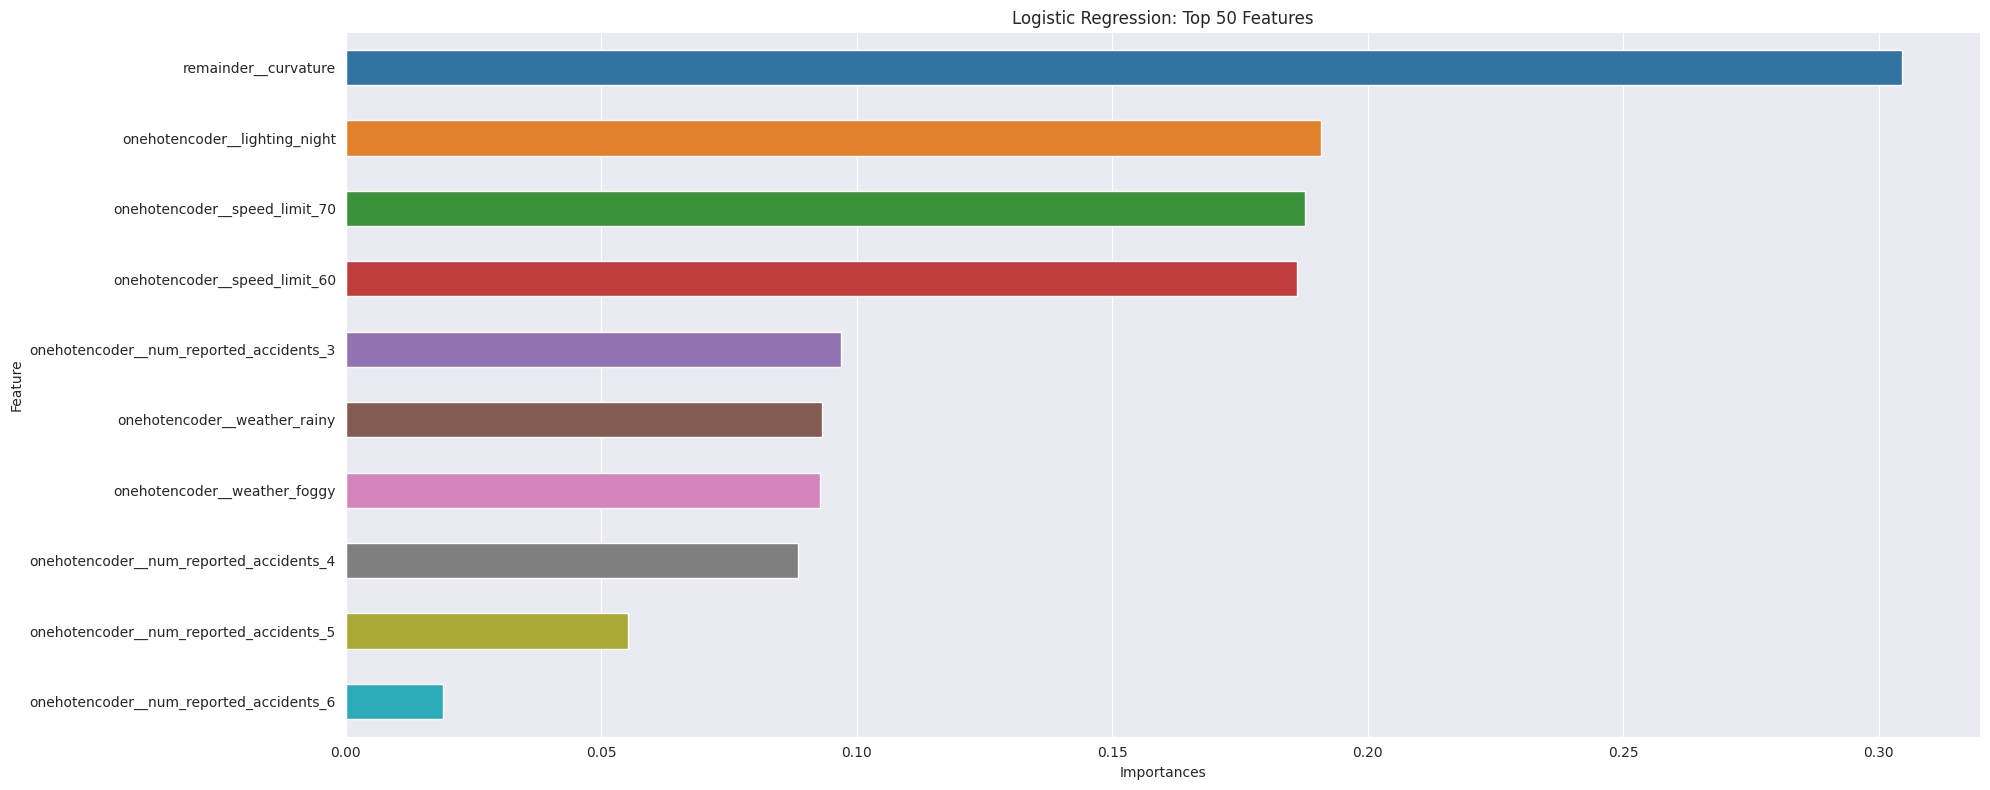

In [16]:
## -- PLOT FEATURES IMPORTANCES --
plt.figure(figsize=(20, 8))
sns.barplot(data=imp_df.iloc[:10, :], x='Importances', y='Feature', width=0.5)
plt.title("Logistic Regression: Top 50 Features")
plt.tight_layout()
plt.show()

In [17]:
## -- Split data --
X_test = test.copy()

X.shape, y.shape, X_test.shape

((517754, 12), (517754,), (172585, 12))

In [18]:
## -- Define Training Parameters --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")
## -----------------------------------------------
MODELS = {}
FOLDS  = 8
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
## -- Initiate Training --
## -----------------------------------------------
oof_preds  = np.zeros(len(X))
test_preds = np.zeros(len(test))
fold_scores = []
## -----------------------------------------------
tik = time()
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print('|', '-'*20)
    print(f"Fold {fold+1}/{FOLDS}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    ## -- Create pipeline --
    model = make_pipeline(
        make_column_transformer(
            (OneHotEncoder(handle_unknown='ignore', drop='first', dtype=int), cat_cols),
            remainder='passthrough', n_jobs=-1,
        ),
        # StandardScaler(),
        LinearRegression(),
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    oof_preds[val_idx] = y_pred

    predictions = model.predict(X_test)
    test_preds += predictions / FOLDS

    score = np.sqrt(mean_squared_error(y_val, y_pred))
    fold_scores.append(score)
    MODELS[f"model-{fold+1}"] = model

    print(f"{COLOR}\tAUC: {score:.6f}{RESET}")

    sleep(2); gc.collect(); sleep(2)

tok = time()
tiktok = (tok-tik)/60
print('-'*20)
print(f"\tTraining Time: {tiktok:.2f} mins{RESET}")

ℹ️ Device: CPU 4 cores
| --------------------
Fold 1/8
	AUC: 0.057962
| --------------------
Fold 2/8
	AUC: 0.058501
| --------------------
Fold 3/8
	AUC: 0.057989
| --------------------
Fold 4/8
	AUC: 0.058009
| --------------------
Fold 5/8
	AUC: 0.057957
| --------------------
Fold 6/8
	AUC: 0.057844
| --------------------
Fold 7/8
	AUC: 0.057928
| --------------------
Fold 8/8
	AUC: 0.057889
--------------------
	Training Time: 1.00 mins


In [19]:
## -- After all folds --
overall_rmse = np.sqrt(mean_squared_error(y, oof_preds))
print(f"|{'-'*30}{COLOR}")
print(f"| Overall AUC: {overall_rmse:.6f}")
print(f"| Average AUC: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")

|------------------------------
| Overall AUC: 0.058010
| Average AUC: 0.058010 ± 0.000192


In [20]:
sorted(MODELS['model-1'][-1].coef_, reverse=True)[:10]

[0.30478689968185874,
 0.19088686789392423,
 0.18769765805133318,
 0.18613163508493064,
 0.09692793710116951,
 0.09326397977178744,
 0.09285813353228468,
 0.08878971677621852,
 0.05095431883982819,
 0.016512449968954217]

In [21]:
## -- Get feature names and importance values --
feature_names = MODELS['model-1'][0].get_feature_names_out(X.columns)
importances = MODELS['model-1'][-1].coef_
imp = dict(Feature=feature_names, Importances=importances)
imp_df = pd.DataFrame(imp).sort_values("Importances", ascending=False)
imp_df.iloc[:10, :]

,Feature,Importances
26,remainder__curvature,0.304787
17,onehotencoder__lighting_night,0.190887
6,onehotencoder__speed_limit_70,0.187698
5,onehotencoder__speed_limit_60,0.186132
9,onehotencoder__num_reported_accidents_3,0.096928
19,onehotencoder__weather_rainy,0.093264
18,onehotencoder__weather_foggy,0.092858
10,onehotencoder__num_reported_accidents_4,0.088790
11,onehotencoder__num_reported_accidents_5,0.050954
12,onehotencoder__num_reported_accidents_6,0.016512


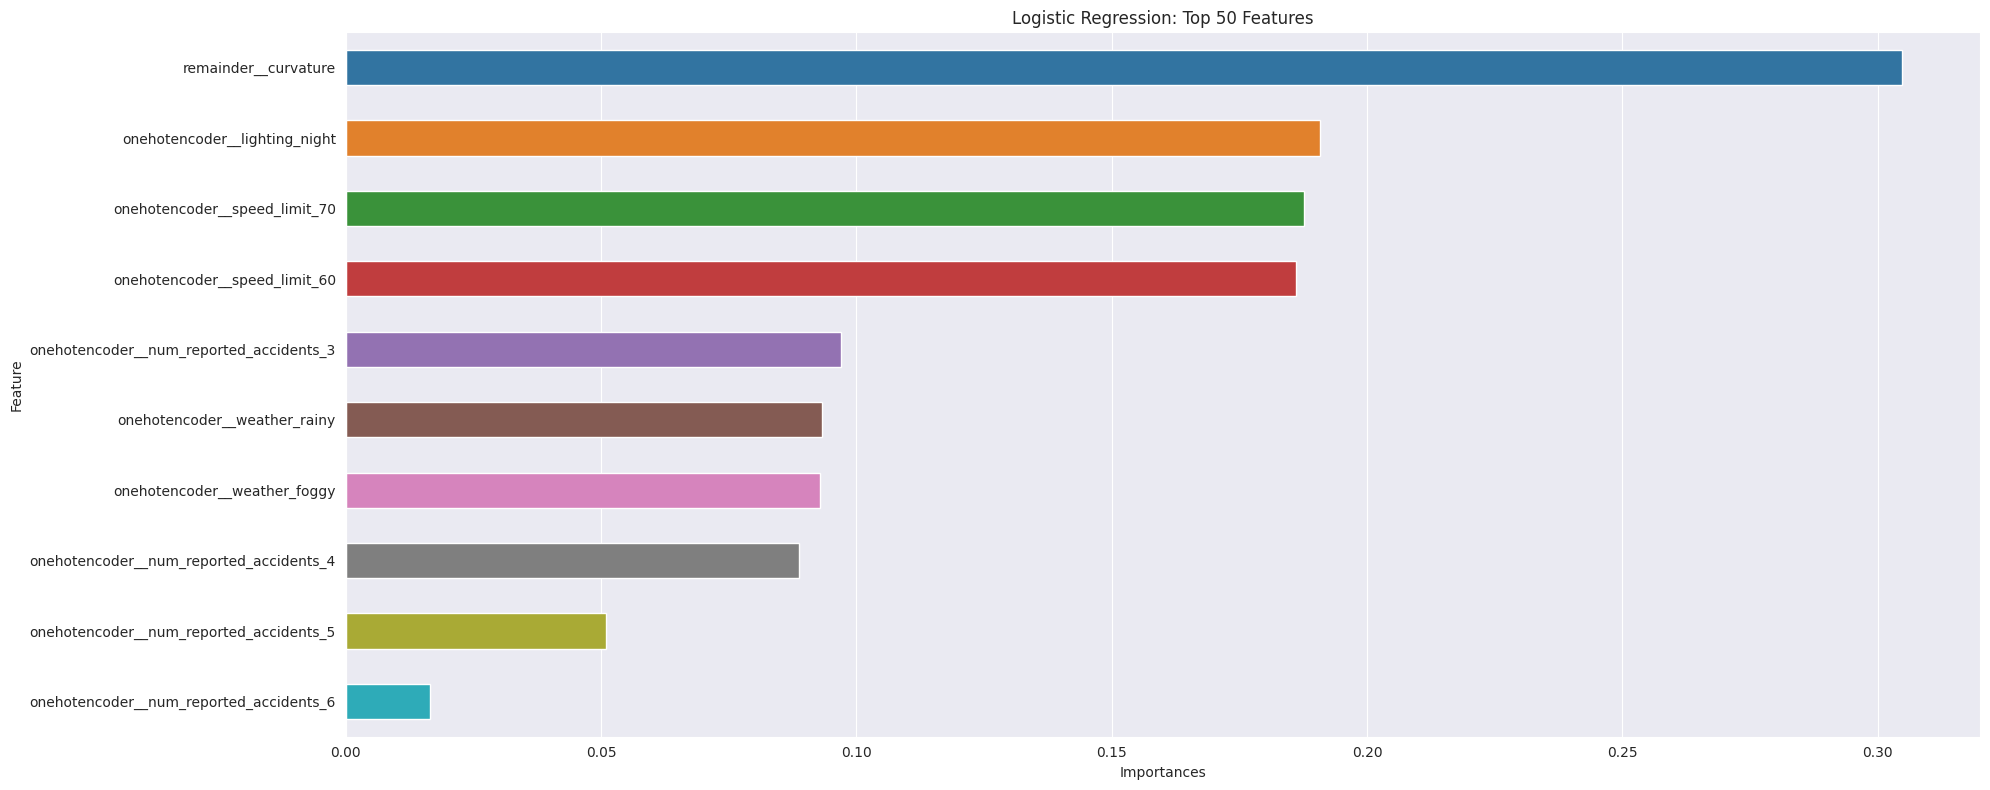

In [22]:
## -- PLOT FEATURES IMPORTANCES --
plt.figure(figsize=(20, 8))

sns.barplot(data=imp_df.iloc[:10, :], x='Importances', y='Feature', width=0.5)
plt.title("Logistic Regression: Top 50 Features")
plt.tight_layout()
plt.show()